# Flat Image Net - Visualize embedding

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os
import shutil
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from PIL import Image
from utils.data import init_dir

## Load data

In [3]:
data = input_data.read_data_sets('/data/fashion/', one_hot=True)
img_shape = (28, 28)
class_id2class_name_mapping = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'}

Extracting /data/fashion/train-images-idx3-ubyte.gz
Extracting /data/fashion/train-labels-idx1-ubyte.gz
Extracting /data/fashion/t10k-images-idx3-ubyte.gz
Extracting /data/fashion/t10k-labels-idx1-ubyte.gz


## Build Net Graph

In [4]:
from utils.nn_graph import simple_layer
from utils.nn_visualization import variable_summaries, img_summaries

graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('flat_image_net_inputs'):
        images = tf.placeholder(tf.float32, shape=[None, 784], name='images')
        labels = tf.placeholder(tf.float32, shape=[None, 10], name='labels')
        keep_dropout_prob = tf.placeholder(tf.float32, name='keep_dropout_prob')

    
    with tf.variable_scope('simple_layer_1'):
        raw_prediction = simple_layer(name='layer1', input_data=images, shape=[784, 64], activation='relu')
        
    with tf.variable_scope('simple_layer_2'):
        raw_prediction = simple_layer(name='layer2', input_data=raw_prediction, shape=[64, 10])
        raw_prediction = tf.nn.dropout(raw_prediction, keep_dropout_prob)
            
    with tf.name_scope('prediction'):
        prediction = tf.nn.softmax(raw_prediction)
    
    with tf.name_scope('loss'):
        cross_entropy_vector = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=prediction)
        loss = tf.reduce_mean(cross_entropy_vector)
        variable_summaries('loss_summary', cross_entropy_vector)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)
        variable_summaries('accuracy_summary', correct_prediction)       
        
    with tf.name_scope('training'):
        train_step = tf.train.AdamOptimizer(0.001).minimize(loss)

    with tf.name_scope("embedding_visualization"):
        embedding = tf.Variable(tf.zeros([5000, 10]), name='valid_embedding')
        embedding_assignment = embedding.assign(raw_prediction)
            
    initialize_vars = tf.global_variables_initializer()
    merge_summaries = tf.summary.merge_all()

## Init Model Logging

In [5]:
from utils.data import init_model_logging
base_dir = '/tensorboard_summaries/flat_image_net/'

logging_meta = init_model_logging(base_dir, 'experiment_visual_embedding', graph=graph, remove_existing=True)

## Data for Embedding Projection

#### Sprite Img

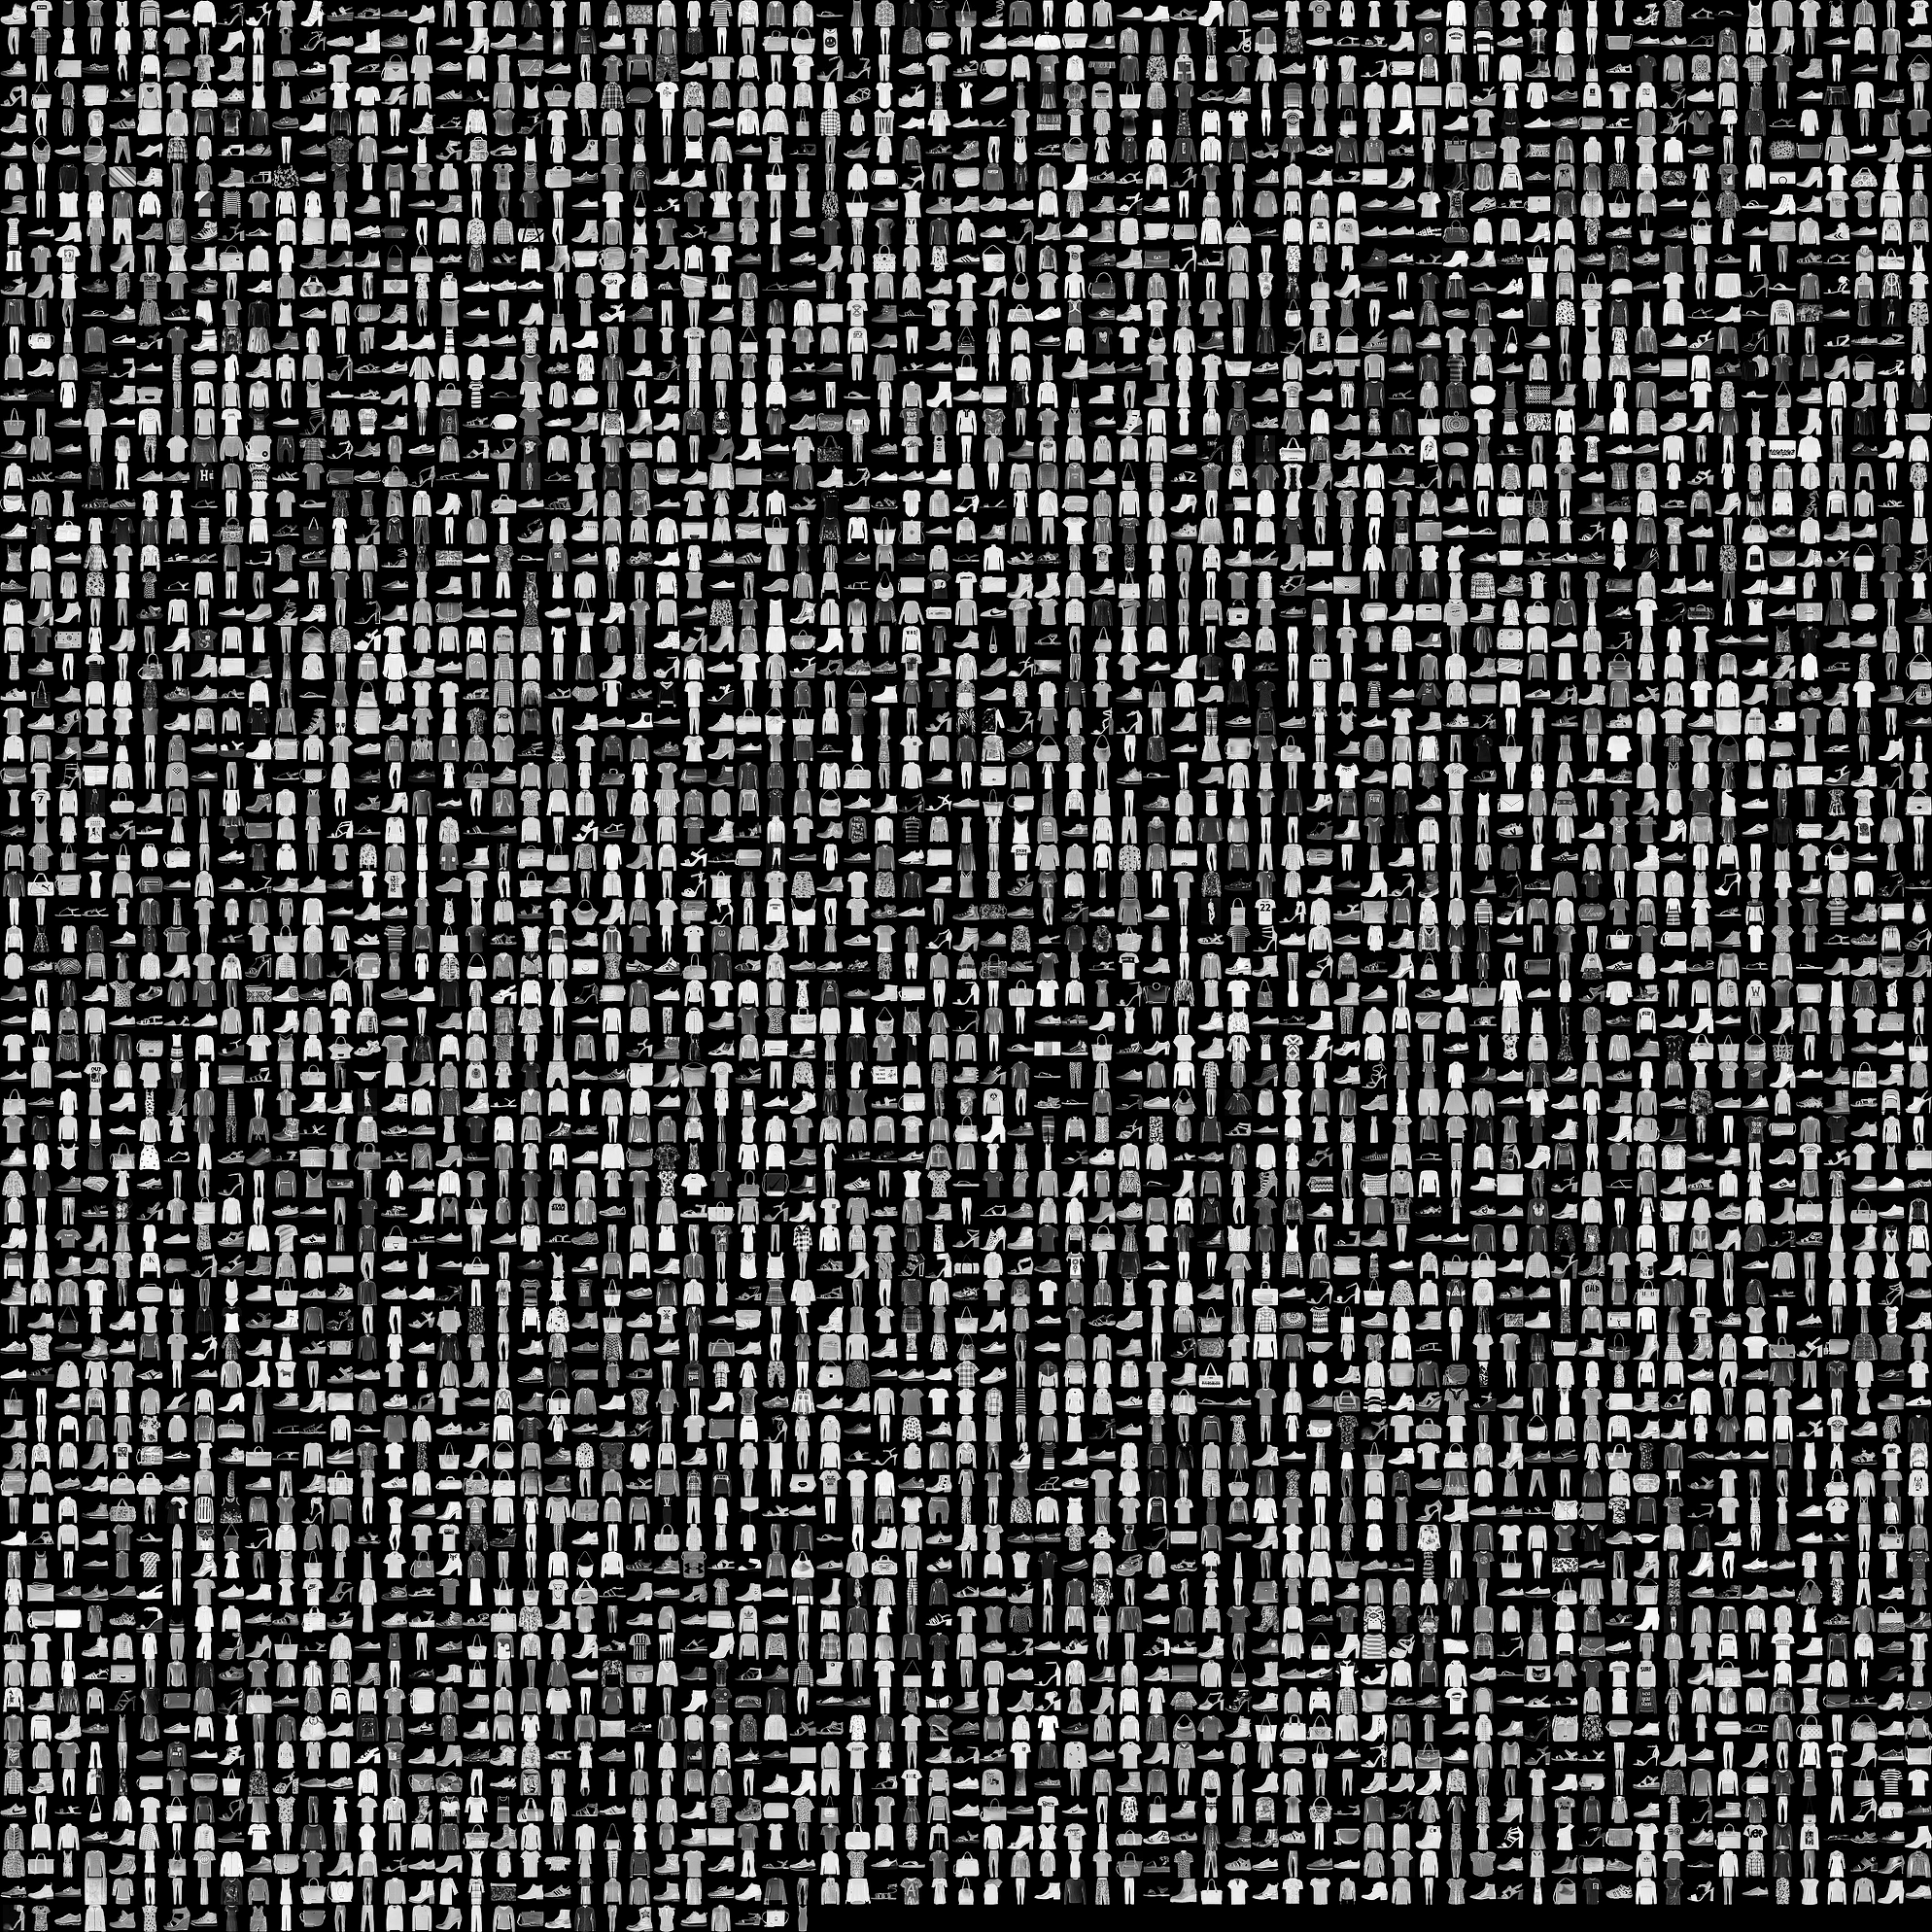

In [6]:
from utils.nn_visualization import get_sprite_img
sprite_img = get_sprite_img(data.validation.images, img_shape)
sprite_img

#### Label Class Names

In [7]:
from utils.nn_visualization import get_label_class_names
label_names = get_label_class_names(data.validation.labels, class_id2class_name_mapping)
label_names

['Ankle boot',
 'T-shirt/top',
 'T-shirt/top',
 'Dress',
 'T-shirt/top',
 'Pullover',
 'Sneaker',
 'Pullover',
 'Sandal',
 'Sandal',
 'T-shirt/top',
 'Ankle boot',
 'Sandal',
 'Sandal',
 'Sneaker',
 'Ankle boot',
 'Trouser',
 'T-shirt/top',
 'Shirt',
 'Coat',
 'Dress',
 'Trouser',
 'Coat',
 'Bag',
 'Coat',
 'Dress',
 'T-shirt/top',
 'Pullover',
 'Coat',
 'Coat',
 'Sandal',
 'Dress',
 'Shirt',
 'Shirt',
 'T-shirt/top',
 'Bag',
 'Sandal',
 'Pullover',
 'Trouser',
 'Shirt',
 'Shirt',
 'Sneaker',
 'Ankle boot',
 'Sandal',
 'Ankle boot',
 'Pullover',
 'Sneaker',
 'Dress',
 'T-shirt/top',
 'Dress',
 'Dress',
 'Dress',
 'Sneaker',
 'Pullover',
 'Pullover',
 'Shirt',
 'Shirt',
 'Bag',
 'Dress',
 'Dress',
 'Sandal',
 'T-shirt/top',
 'Sandal',
 'Sandal',
 'T-shirt/top',
 'Pullover',
 'T-shirt/top',
 'T-shirt/top',
 'Coat',
 'Trouser',
 'Dress',
 'Trouser',
 'Shirt',
 'Dress',
 'Trouser',
 'Coat',
 'Coat',
 'Shirt',
 'Trouser',
 'Ankle boot',
 'Trouser',
 'Dress',
 'Sandal',
 'Sneaker',
 'Ankle b

## Add Embedding Projection

In [8]:
from utils.nn_visualization import init_embedding_projector, init_embedding_data

init_embedding_data(logging_meta['valid_writer_dir'], sprite_img, label_names)
init_embedding_projector(logging_meta['valid_writer'], embedding, img_shape)

## Run Net

In [9]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
model_path = logging_meta['model_path']
        
with tf.Session(graph=graph, config=config) as session:
    session.run(initialize_vars)
    for iteration in range(10000):
        ##################
        # Training phase #
        ##################
        _images, _labels = data.train.next_batch(100)
        _ = session.run([train_step], feed_dict={images: _images, labels: _labels, keep_dropout_prob: 0.5})
        if iteration % 10 == 0:
            _summary, _accuracy, _loss = session.run([merge_summaries, accuracy, loss],
                                                     feed_dict={images: _images, 
                                                                labels: _labels, 
                                                                keep_dropout_prob: 1.0})
            logging_meta['train_writer'].add_summary(_summary, iteration)
            print("Train Iteration {}: loss {}, accuracy {}".format(iteration, _loss, _accuracy))
      
        ####################
        # Validation phase #
        ####################
        if iteration % 100 == 0:
            _, _summary, _accuracy, _loss = session.run([embedding_assignment, merge_summaries, accuracy, loss], 
                                          feed_dict={images: data.validation.images, 
                                                     labels: data.validation.labels,
                                                     keep_dropout_prob: 1.0})
            logging_meta['valid_writer'].add_summary(_summary, iteration)
            logging_meta['saver'].save(session, model_path, iteration)
            print("= Valid Iteration {}: loss {}, accuracy {} =".format(iteration, _loss, _accuracy))
            
    _prediction, = session.run([prediction], feed_dict={images: data.validation.images, keep_dropout_prob: 1.0})

Train Iteration 0: loss 2.286330223083496, accuracy 0.30000001192092896
= Valid Iteration 0: loss 2.2929258346557617, accuracy 0.1964000016450882 =
Train Iteration 10: loss 2.15158748626709, accuracy 0.3400000035762787
Train Iteration 20: loss 2.166642189025879, accuracy 0.3700000047683716
Train Iteration 30: loss 1.9576977491378784, accuracy 0.7300000190734863
Train Iteration 40: loss 1.9810305833816528, accuracy 0.6000000238418579
Train Iteration 50: loss 1.9075193405151367, accuracy 0.6399999856948853
Train Iteration 60: loss 1.9044249057769775, accuracy 0.6899999976158142
Train Iteration 70: loss 1.8447102308273315, accuracy 0.7599999904632568
Train Iteration 80: loss 1.8486040830612183, accuracy 0.6899999976158142
Train Iteration 90: loss 1.8280905485153198, accuracy 0.6800000071525574
Train Iteration 100: loss 1.834226369857788, accuracy 0.7099999785423279
= Valid Iteration 100: loss 1.8498562574386597, accuracy 0.6710000038146973 =
Train Iteration 110: loss 1.8572802543640137, a

Train Iteration 1100: loss 1.6952978372573853, accuracy 0.7699999809265137
= Valid Iteration 1100: loss 1.7515796422958374, accuracy 0.7166000008583069 =
Train Iteration 1110: loss 1.8390158414840698, accuracy 0.6299999952316284
Train Iteration 1120: loss 1.738418459892273, accuracy 0.7300000190734863
Train Iteration 1130: loss 1.802475929260254, accuracy 0.6800000071525574
Train Iteration 1140: loss 1.8751553297042847, accuracy 0.5799999833106995
Train Iteration 1150: loss 1.8719333410263062, accuracy 0.6000000238418579
Train Iteration 1160: loss 1.870581865310669, accuracy 0.5799999833106995
Train Iteration 1170: loss 1.7580749988555908, accuracy 0.7099999785423279
Train Iteration 1180: loss 1.7663369178771973, accuracy 0.6899999976158142
Train Iteration 1190: loss 1.7666882276535034, accuracy 0.699999988079071
Train Iteration 1200: loss 1.7189701795578003, accuracy 0.75
= Valid Iteration 1200: loss 1.7520170211791992, accuracy 0.7138000130653381 =
Train Iteration 1210: loss 1.763919

Train Iteration 2110: loss 1.7465344667434692, accuracy 0.7099999785423279
Train Iteration 2120: loss 1.716206669807434, accuracy 0.7400000095367432
Train Iteration 2130: loss 1.8100662231445312, accuracy 0.6399999856948853
Train Iteration 2140: loss 1.8317055702209473, accuracy 0.6399999856948853
Train Iteration 2150: loss 1.6875015497207642, accuracy 0.7799999713897705
Train Iteration 2160: loss 1.7184933423995972, accuracy 0.75
Train Iteration 2170: loss 1.7476806640625, accuracy 0.7300000190734863
Train Iteration 2180: loss 1.754966378211975, accuracy 0.7200000286102295
Train Iteration 2190: loss 1.7613589763641357, accuracy 0.7099999785423279
Train Iteration 2200: loss 1.74031662940979, accuracy 0.7200000286102295
= Valid Iteration 2200: loss 1.7427754402160645, accuracy 0.7218000292778015 =
Train Iteration 2210: loss 1.7079333066940308, accuracy 0.7599999904632568
Train Iteration 2220: loss 1.730959415435791, accuracy 0.7400000095367432
Train Iteration 2230: loss 1.73979282379150

= Valid Iteration 3200: loss 1.7354103326797485, accuracy 0.728600025177002 =
Train Iteration 3210: loss 1.7357181310653687, accuracy 0.7300000190734863
Train Iteration 3220: loss 1.7276504039764404, accuracy 0.7400000095367432
Train Iteration 3230: loss 1.732216238975525, accuracy 0.7200000286102295
Train Iteration 3240: loss 1.7601832151412964, accuracy 0.6899999976158142
Train Iteration 3250: loss 1.7047866582870483, accuracy 0.75
Train Iteration 3260: loss 1.7530556917190552, accuracy 0.7099999785423279
Train Iteration 3270: loss 1.6902192831039429, accuracy 0.7699999809265137
Train Iteration 3280: loss 1.7760745286941528, accuracy 0.699999988079071
Train Iteration 3290: loss 1.7172900438308716, accuracy 0.7599999904632568
Train Iteration 3300: loss 1.7306854724884033, accuracy 0.7300000190734863
= Valid Iteration 3300: loss 1.7334951162338257, accuracy 0.7279999852180481 =
Train Iteration 3310: loss 1.7147793769836426, accuracy 0.75
Train Iteration 3320: loss 1.721671462059021, ac

= Valid Iteration 4200: loss 1.7325917482376099, accuracy 0.7265999913215637 =
Train Iteration 4210: loss 1.6666635274887085, accuracy 0.7900000214576721
Train Iteration 4220: loss 1.8034521341323853, accuracy 0.6499999761581421
Train Iteration 4230: loss 1.7511649131774902, accuracy 0.7200000286102295
Train Iteration 4240: loss 1.8057740926742554, accuracy 0.6600000262260437
Train Iteration 4250: loss 1.7479946613311768, accuracy 0.699999988079071
Train Iteration 4260: loss 1.7600713968276978, accuracy 0.6899999976158142
Train Iteration 4270: loss 1.8431795835494995, accuracy 0.6200000047683716
Train Iteration 4280: loss 1.7701181173324585, accuracy 0.6899999976158142
Train Iteration 4290: loss 1.7032719850540161, accuracy 0.7400000095367432
Train Iteration 4300: loss 1.7328917980194092, accuracy 0.7300000190734863
= Valid Iteration 4300: loss 1.7306945323944092, accuracy 0.7332000136375427 =
Train Iteration 4310: loss 1.6922094821929932, accuracy 0.7699999809265137
Train Iteration 43

Train Iteration 5250: loss 1.7331609725952148, accuracy 0.7400000095367432
Train Iteration 5260: loss 1.6620773077011108, accuracy 0.800000011920929
Train Iteration 5270: loss 1.7532296180725098, accuracy 0.6899999976158142
Train Iteration 5280: loss 1.6741751432418823, accuracy 0.7900000214576721
Train Iteration 5290: loss 1.7261892557144165, accuracy 0.7400000095367432
Train Iteration 5300: loss 1.700078010559082, accuracy 0.75
= Valid Iteration 5300: loss 1.7285979986190796, accuracy 0.732200026512146 =
Train Iteration 5310: loss 1.7077209949493408, accuracy 0.7599999904632568
Train Iteration 5320: loss 1.6904107332229614, accuracy 0.7799999713897705
Train Iteration 5330: loss 1.6569299697875977, accuracy 0.8299999833106995
Train Iteration 5340: loss 1.7587875127792358, accuracy 0.7099999785423279
Train Iteration 5350: loss 1.7091872692108154, accuracy 0.75
Train Iteration 5360: loss 1.6808421611785889, accuracy 0.7799999713897705
Train Iteration 5370: loss 1.7414299249649048, accur

Train Iteration 6280: loss 1.7092126607894897, accuracy 0.7599999904632568
Train Iteration 6290: loss 1.7433475255966187, accuracy 0.7300000190734863
Train Iteration 6300: loss 1.7055853605270386, accuracy 0.75
= Valid Iteration 6300: loss 1.7261669635772705, accuracy 0.7360000014305115 =
Train Iteration 6310: loss 1.7023776769638062, accuracy 0.7599999904632568
Train Iteration 6320: loss 1.6545709371566772, accuracy 0.8100000023841858
Train Iteration 6330: loss 1.7473002672195435, accuracy 0.7099999785423279
Train Iteration 6340: loss 1.7441864013671875, accuracy 0.7200000286102295
Train Iteration 6350: loss 1.682644009590149, accuracy 0.7799999713897705
Train Iteration 6360: loss 1.7833716869354248, accuracy 0.6800000071525574
Train Iteration 6370: loss 1.7156540155410767, accuracy 0.7400000095367432
Train Iteration 6380: loss 1.7676528692245483, accuracy 0.6899999976158142
Train Iteration 6390: loss 1.7322522401809692, accuracy 0.7300000190734863
Train Iteration 6400: loss 1.7613570

Train Iteration 7360: loss 1.6925239562988281, accuracy 0.7699999809265137
Train Iteration 7370: loss 1.7164077758789062, accuracy 0.75
Train Iteration 7380: loss 1.7200703620910645, accuracy 0.7400000095367432
Train Iteration 7390: loss 1.722178339958191, accuracy 0.7400000095367432
Train Iteration 7400: loss 1.7701514959335327, accuracy 0.6899999976158142
= Valid Iteration 7400: loss 1.7309890985488892, accuracy 0.7311999797821045 =
Train Iteration 7410: loss 1.6914845705032349, accuracy 0.7699999809265137
Train Iteration 7420: loss 1.7412365674972534, accuracy 0.7200000286102295
Train Iteration 7430: loss 1.745091438293457, accuracy 0.7300000190734863
Train Iteration 7440: loss 1.6904278993606567, accuracy 0.7699999809265137
Train Iteration 7450: loss 1.7106512784957886, accuracy 0.75
Train Iteration 7460: loss 1.68892240524292, accuracy 0.7699999809265137
Train Iteration 7470: loss 1.7934635877609253, accuracy 0.6600000262260437
Train Iteration 7480: loss 1.782467007637024, accurac

Train Iteration 8370: loss 1.7284671068191528, accuracy 0.7300000190734863
Train Iteration 8380: loss 1.7845396995544434, accuracy 0.6800000071525574
Train Iteration 8390: loss 1.7002606391906738, accuracy 0.7599999904632568
Train Iteration 8400: loss 1.7522586584091187, accuracy 0.7099999785423279
= Valid Iteration 8400: loss 1.7241590023040771, accuracy 0.7361999750137329 =
Train Iteration 8410: loss 1.7397898435592651, accuracy 0.7300000190734863
Train Iteration 8420: loss 1.7093017101287842, accuracy 0.75
Train Iteration 8430: loss 1.776527762413025, accuracy 0.6899999976158142
Train Iteration 8440: loss 1.7256827354431152, accuracy 0.7400000095367432
Train Iteration 8450: loss 1.6947215795516968, accuracy 0.7599999904632568
Train Iteration 8460: loss 1.7298849821090698, accuracy 0.7300000190734863
Train Iteration 8470: loss 1.7775460481643677, accuracy 0.6899999976158142
Train Iteration 8480: loss 1.629326343536377, accuracy 0.8299999833106995
Train Iteration 8490: loss 1.68663823

Train Iteration 9450: loss 1.7710351943969727, accuracy 0.6899999976158142
Train Iteration 9460: loss 1.6508108377456665, accuracy 0.8100000023841858
Train Iteration 9470: loss 1.7673813104629517, accuracy 0.6899999976158142
Train Iteration 9480: loss 1.719618797302246, accuracy 0.7300000190734863
Train Iteration 9490: loss 1.724371075630188, accuracy 0.7300000190734863
Train Iteration 9500: loss 1.6733380556106567, accuracy 0.7900000214576721
= Valid Iteration 9500: loss 1.7236422300338745, accuracy 0.7364000082015991 =
Train Iteration 9510: loss 1.7515759468078613, accuracy 0.7200000286102295
Train Iteration 9520: loss 1.6745307445526123, accuracy 0.7900000214576721
Train Iteration 9530: loss 1.7195113897323608, accuracy 0.75
Train Iteration 9540: loss 1.72904634475708, accuracy 0.7200000286102295
Train Iteration 9550: loss 1.729331374168396, accuracy 0.7300000190734863
Train Iteration 9560: loss 1.7611289024353027, accuracy 0.699999988079071
Train Iteration 9570: loss 1.743764400482